In [1]:
import cv2 as cv
import keras
import keras.applications as apps
import numpy as np
import os
import densenet
import densenet_noise
import glob
import tqdm
import matplotlib.pyplot as plt
import matplotlib
import shutil
import random
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/paperspace/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network constants
TILE_SIZE = 321
INPUT_CHANNELS = 2 # HH, HV
CLASSES = 1 # regression
RANDOM_SEED = 1 # for consistency in test/train split
TRAINING_PATH = 'training_data/20*'

### Three networks used

In [3]:
# Network 1: No modifications, simple densenet
normal_net = densenet.DenseNet121(include_top=True,
                      weights=None,
                      input_shape=(TILE_SIZE, TILE_SIZE, INPUT_CHANNELS),
                      pooling=None,
                      classes=CLASSES)
# Network 2: Densenet with initial gaussian noise layrer 
noise_net = densenet_noise.DenseNet121(include_top=True,
                      weights=None,
                      input_shape=(TILE_SIZE, TILE_SIZE, INPUT_CHANNELS),
                      pooling=None,
                      classes=CLASSES)
# Network 3: Normal Densenet but using weights from network 2 initially
net = densenet.DenseNet121(include_top=True,
                      weights=None,
                      input_shape=(TILE_SIZE, TILE_SIZE, INPUT_CHANNELS),
                      pooling=None,
                      classes=CLASSES)

/home/paperspace/anaconda3/lib/python3.6/site-packages/keras/applications/imagenet_utils.py:258: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


In [4]:
# Utility methods to process/load images
def is_data_valid(folder_path):
    valid = os.path.exists(os.path.join(folder_path, 'imagery_HH.tif'))
    valid = valid and os.path.exists(os.path.join(folder_path, 'imagery_HV.tif')) 
    valid = valid and os.path.exists(os.path.join(folder_path, 'conc.tiff'))
    return valid

def read_data(folder):
    hh_image = cv.imread(os.path.join(folder, 'imagery_HH.tif'), cv.IMREAD_GRAYSCALE)
    hv_image = cv.imread(os.path.join(folder, 'imagery_HV.tif'), cv.IMREAD_GRAYSCALE)
    conc_image = cv.imread(os.path.join(folder, 'conc.tiff'), cv.IMREAD_GRAYSCALE)
    return hh_image, hv_image, conc_image

def tile_image(HH, HV, conc, tile_size=221):
    # This function assumes all images are the same shape
    tile_center = tile_size//2
    amount_x = (HH.shape[0]//tile_size) -1
    amount_y = (HH.shape[1]//tile_size) -1
    sar_tiles = []
    conc_tiles = []
    for i in range(amount_x):
        for j in range(amount_y):
            x_bounds = [tile_size*i, tile_size*(i+1)]
            y_bounds = [tile_size*j, tile_size*(j+1)]
            conc_tile = conc[x_bounds[0]:x_bounds[1], y_bounds[0]:y_bounds[1]]
            # check if the center of the tile is land or not
            if conc_tile[tile_center, tile_center] != 255:
                # set all values within the SAR image to by 255 if that part of the image is land
                HH_tile = np.where(conc_tile == 255,255,HH[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                HV_tile = np.where(conc_tile == 255, 255, HV[x_bounds[0]:x_bounds[1],y_bounds[0]:y_bounds[1]])
                tile = np.stack([HH_tile, HV_tile],axis=-1)
                sar_tiles.append(tile)
                conc_tiles.append([conc_tile[tile_center, tile_center]])
    sar_tiles = np.asarray(sar_tiles).astype(np.float32)/255
    conc_tiles = np.asarray(conc_tiles).astype(np.float32)/100
    
    return sar_tiles, conc_tiles

def gen_tile_data(folder_name, images, labels, pos, dry_run=False, multiplier=1):
    amount = 0
    try:
        SHIFT = TILE_SIZE//multiplier
        hh_image, hv_image, conc_image = read_data(folder_name)
        conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
        for _ in range(multiplier):
            hh_image = hh_image[SHIFT:, SHIFT:]
            hv_image = hv_image[SHIFT:, SHIFT:]
            conc_image_big = conc_image_big[SHIFT:, SHIFT:]
            im_tiles, c_tiles = tile_image(hh_image, hv_image, conc_image_big, tile_size=TILE_SIZE)
            if not dry_run:
                images[pos+amount:pos + amount+ len(im_tiles)] = im_tiles
                labels[pos+amount:pos + amount + len(c_tiles)] = c_tiles
            amount = amount + len(im_tiles)
    except:
        print(folder_name)
    if dry_run:
        return amount
    return images, labels, pos + amount

Generating the test/train split by randomly selecting a series of image folders for each. Images are kept independent from each other

In [5]:
folders = [f for f in glob.glob(os.path.join('training_data/20*')) if is_data_valid(f)]
random.seed(RANDOM_SEED)
rand_folders = sorted(folders, key=lambda f: random.random())
# 17% test/train split (roughly as using independent images)
train_amount = len(rand_folders)//6
training_folders = rand_folders[:-train_amount]
testing_folders = rand_folders[-train_amount:]

In [6]:
len(training_folders)

23

In [7]:
testing_folders

['training_data/20110405',
 'training_data/20101009B',
 'training_data/20110217',
 'training_data/20110223']

## Allocating arrays pre-emptively to save space

In [8]:
train_length = 0
for k, folder in enumerate(tqdm.tqdm(training_folders)):
    train_length += gen_tile_data(folder, None, None, pos=0, dry_run=True, multiplier=2)
test_length = 0
for k, folder in enumerate(tqdm.tqdm(testing_folders)):
    test_length += gen_tile_data(folder, None, None, pos=0, dry_run=True, multiplier=2)
    
training_images = np.zeros((train_length, TILE_SIZE, TILE_SIZE, 2), dtype=np.float32)
training_labels = np.zeros((train_length, 1), dtype=np.float32)

testing_images = np.zeros((test_length, TILE_SIZE, TILE_SIZE, 2), dtype=np.float32)
testing_labels = np.zeros((test_length, 1), dtype=np.float32)

 13%|█▎        | 3/23 [00:05<00:33,  1.69s/it]

training_data/20110717B


 74%|███████▍  | 17/23 [00:35<00:12,  2.06s/it]

training_data/20110214


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


In [9]:
test_length

4750

In [10]:
train_length

18800

In [11]:
# ALTERNATE
if False:
    length = 0
    for k, folder in enumerate(tqdm.tqdm(training_folders + testing_folders)):
        length += gen_tile_data(folder, None, None, pos=0, dry_run=True)
    images = np.zeros((length, TILE_SIZE, TILE_SIZE, 2), dtype=np.float32)
    labels = np.zeros((length, 1), dtype=np.float32)

    pos = 0
    for k, folder in enumerate(tqdm.tqdm(training_folders + testing_folders)):
        images, labels, pos = gen_tile_data(folder, images, labels, pos)
    training_length = int(length - length//7)
    testing_images = images[training_length:]
    testing_labels = labels[training_length:]
    
    images = images[:training_length]
    labels = labels[:training_length]
    training_images = images
    training_labels = labels
#     pos = 0
#     for k, folder in enumerate(tqdm.tqdm(testing_folders)):
#         testing_images, testing_labels, pos = gen_tile_data(folder, testing_images, testing_labels, pos)
# training_images = np.zeros((train_length, TILE_SIZE, TILE_SIZE, 2), dtype=np.float32)
# training_labels = np.zeros((train_length, 1), dtype=np.float32)
# 
# testing_images = np.zeros((test_length, TILE_SIZE, TILE_SIZE, 2), dtype=np.float32)
# testing_labels = np.zeros((test_length, 1), dtype=np.float32)

Generating the training data from the images and their corresponding concentration labels

In [12]:
pos = 0
for k, folder in enumerate(tqdm.tqdm(training_folders)):
    training_images, training_labels, pos = gen_tile_data(folder, training_images, training_labels, pos, multiplier=2)

pos = 0
for k, folder in enumerate(tqdm.tqdm(testing_folders)):
    testing_images, testing_labels, pos = gen_tile_data(folder, testing_images, testing_labels, pos, multiplier=2)

 13%|█▎        | 3/23 [00:03<00:26,  1.31s/it]

training_data/20110717B


 74%|███████▍  | 17/23 [00:28<00:09,  1.65s/it]

training_data/20110214


100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


In [13]:
# mixing the training data

### Training

Network #1

In [24]:
optimizer = keras.optimizers.Adam(lr=0.001)
loss = 'mean_absolute_error'
normal_net.compile(optimizer, loss=loss)

In [23]:
checkpointer = ModelCheckpoint(filepath='weights/normal_checkpoint_LARGE2.hdf5', verbose=1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1),
                                    cooldown=0, patience=3, min_lr=1e-5)

In [14]:
hist_loss_normal = []
val_loss_normal = []

In [21]:
normal_net.load_weights("weights/normal_save_LARGE2.hdf5")

In [16]:
normal_net.evaluate(x=training_images, y=training_labels)

18800/18800 [==============================] - 218s 12ms/step


0.190503489682382

In [20]:
normal_net.metrics

[]

In [27]:
normal_net.evaluate(x=testing_images, y=testing_labels)

4750/4750 [==============================] - 54s 11ms/step


0.058460242823354505

In [25]:
# Using loop to save loss data between epochs
normal_net.fit(x=training_images, y=training_labels, epochs=500, validation_data=(testing_images, testing_labels), callbacks=[checkpointer, lr_reducer])

Train on 18800 samples, validate on 4750 samples
Epoch 1/500
18800/18800 [==============================] - 569s 30ms/step - loss: 0.0714 - val_loss: 0.1305

Epoch 00001: val_loss improved from inf to 0.13048, saving model to weights/normal_checkpoint_LARGE2.hdf5
Epoch 2/500
18800/18800 [==============================] - 558s 30ms/step - loss: 0.0709 - val_loss: 0.0646

Epoch 00002: val_loss improved from 0.13048 to 0.06457, saving model to weights/normal_checkpoint_LARGE2.hdf5
Epoch 3/500
18800/18800 [==============================] - 559s 30ms/step - loss: 0.0710 - val_loss: 0.0825

Epoch 00003: val_loss did not improve
Epoch 4/500
18800/18800 [==============================] - 559s 30ms/step - loss: 0.0683 - val_loss: 0.2570

Epoch 00004: val_loss did not improve
Epoch 5/500
18800/18800 [==============================] - 559s 30ms/step - loss: 0.0705 - val_loss: 0.0849

Epoch 00005: val_loss did not improve
Epoch 6/500
18800/18800 [==============================] - 558s 30ms/step - 

KeyboardInterrupt: 

In [26]:
normal_net.save_weights("weights/normal_save_LARGE3.hdf5")

In [11]:
# TODO: tune hyper params
optimizer = keras.optimizers.Adam(lr=0.003)
# metrics = ['accuracy']
loss = 'mean_absolute_error'
# loss = 'mean_squared_error'

noise_net.compile(optimizer, loss=loss)


In [12]:
checkpointer = ModelCheckpoint(filepath='weights/noise_checkpoint_LARGE.hdf5', verbose=1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.1),
                                    cooldown=0, patience=3, min_lr=1e-5)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)


In [13]:
hist_loss_noise = []
val_loss_noise = []

Due to the server re-setting it was necessary to reload the model several times from a checkpoint

In [14]:
noise_net.load_weights('weights/noise_checkpoint_LARGE.hdf5')

In [15]:
hist = noise_net.fit(x=training_images, y=training_labels, epochs=500, validation_data=(testing_images, testing_labels), callbacks=[checkpointer, lr_reducer, tensorboard])
hist_loss_noise += hist.history['loss']
val_loss_noise += hist.history['val_loss']

Train on 18800 samples, validate on 4750 samples
Epoch 1/500
18800/18800 [==============================] - 570s 30ms/step - loss: 0.1043 - val_loss: 0.1691

Epoch 00001: val_loss improved from inf to 0.16915, saving model to weights/noise_checkpoint_LARGE.hdf5
Epoch 2/500
18800/18800 [==============================] - 562s 30ms/step - loss: 0.1023 - val_loss: 0.1832

Epoch 00002: val_loss did not improve
Epoch 3/500
18800/18800 [==============================] - 562s 30ms/step - loss: 0.1019 - val_loss: 0.1590

Epoch 00003: val_loss improved from 0.16915 to 0.15895, saving model to weights/noise_checkpoint_LARGE.hdf5
Epoch 4/500
18800/18800 [==============================] - 562s 30ms/step - loss: 0.0996 - val_loss: 0.1328

Epoch 00004: val_loss improved from 0.15895 to 0.13279, saving model to weights/noise_checkpoint_LARGE.hdf5
Epoch 5/500
18800/18800 [==============================] - 562s 30ms/step - loss: 0.1003 - val_loss: 0.1781

Epoch 00005: val_loss did not improve
Epoch 6/50

KeyboardInterrupt: 

In [31]:
hist = noise_net.fit(x=training_images, y=training_labels, epochs=500, validation_data=(testing_images, testing_labels), callbacks=[checkpointer, lr_reducer, tensorboard])
hist_loss_noise += hist.history['loss']
val_loss_noise += hist.history['val_loss']

Train on 18800 samples, validate on 4750 samples
Epoch 1/500
18800/18800 [==============================] - 562s 30ms/step - loss: 0.0747 - val_loss: 0.1047

Epoch 00001: val_loss did not improve
Epoch 2/500
18800/18800 [==============================] - 563s 30ms/step - loss: 0.0773 - val_loss: 0.1962

Epoch 00002: val_loss did not improve
Epoch 3/500
18800/18800 [==============================] - 562s 30ms/step - loss: 0.0784 - val_loss: 0.1218

Epoch 00003: val_loss did not improve
Epoch 4/500
18800/18800 [==============================] - 562s 30ms/step - loss: 0.0757 - val_loss: 0.0837

Epoch 00004: val_loss did not improve
Epoch 5/500
18800/18800 [==============================] - 562s 30ms/step - loss: 0.0750 - val_loss: 0.0883

Epoch 00005: val_loss did not improve
Epoch 6/500
18800/18800 [==============================] - 562s 30ms/step - loss: 0.0673 - val_loss: 0.1040

Epoch 00006: val_loss did not improve
Epoch 7/500
18800/18800 [==============================] - 562s 30ms/

KeyboardInterrupt: 

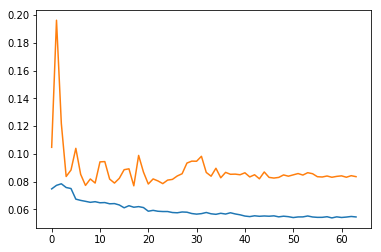

In [32]:
plt.figure()
plt.plot(noise_net.history.history['loss'])
plt.plot(noise_net.history.history['val_loss'])

In [25]:
keras.backend.get_value(noise_net.optimizer.lr)

0.003

In [20]:
noise_net.history.history

{'loss': [0.27690693216120943,
  0.22891299950315597,
  0.21275840824588815,
  0.20683300902234747,
  0.20170738308987718,
  0.19195369956341196,
  0.1812702253714521,
  0.17437229742395116,
  0.16962746355761874,
  0.16233846361332752,
  0.16244656070115718,
  0.15376873601624305,
  0.15049467407642528,
  0.1494616837641026,
  0.14714463731709948,
  0.14680250650390667,
  0.14234559444670983,
  0.13785344129547158,
  0.13862093856994143,
  0.13681516766389634,
  0.13327388335415657,
  0.1318319777478563,
  0.13120414967232563,
  0.12580060865650786,
  0.1252435976520498],
 'lr': [0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003,
  0.003],
 'val_loss': [0.2090218936267652,
  0.23661759085639528,
  0.43058590215130854,
  0.44555508590999404,
  0.186570525112905,
  0.2507457503268593,
  0.1020543137602508,
  0.1084255980419877

In [22]:
keras.backend.set_value(optimizer.lr,0.003/np.sqrt(10))

In [21]:
keras.backend.get_value(optimizer.lr)

0.003

In [25]:
noise_net.save_weights('weights/noise_FINAL.hdf5')

In [14]:
net.load_weights('weights/noise_checkpoint_LARGE.hdf5')

In [15]:
checkpointer = ModelCheckpoint(filepath='weights/net_checkpoint_FINAL_LARGE.hdf5', verbose=1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1),
                                    cooldown=0, patience=3, min_lr=1e-5)

In [16]:
# TODO: tune hyper params
optimizer = keras.optimizers.Adam(lr=0.0001)
# metrics = ['accuracy']
loss = 'mean_absolute_error'
# loss = 'mean_squared_error'

net.compile(optimizer, loss=loss)


In [17]:
hist = net.fit(x=training_images, y=training_labels, epochs=15, validation_data=(testing_images, testing_labels), callbacks=[checkpointer, lr_reducer])
hist_loss_noise += hist.history['loss']
val_loss_noise += hist.history['val_loss']

Train on 18800 samples, validate on 4750 samples
Epoch 1/15
18800/18800 [==============================] - 578s 31ms/step - loss: 0.0642 - val_loss: 0.0879

Epoch 00001: val_loss improved from inf to 0.08791, saving model to weights/net_checkpoint_FINAL_LARGE.hdf5
Epoch 2/15
18800/18800 [==============================] - 561s 30ms/step - loss: 0.0572 - val_loss: 0.0974

Epoch 00002: val_loss did not improve
Epoch 3/15
18800/18800 [==============================] - 561s 30ms/step - loss: 0.0556 - val_loss: 0.0888

Epoch 00003: val_loss did not improve
Epoch 4/15
18800/18800 [==============================] - 561s 30ms/step - loss: 0.0540 - val_loss: 0.0875

Epoch 00004: val_loss improved from 0.08791 to 0.08745, saving model to weights/net_checkpoint_FINAL_LARGE.hdf5
Epoch 5/15
18800/18800 [==============================] - 561s 30ms/step - loss: 0.0534 - val_loss: 0.0803

Epoch 00005: val_loss improved from 0.08745 to 0.08034, saving model to weights/net_checkpoint_FINAL_LARGE.hdf5
Epo

NameError: name 'hist_loss_noise' is not defined

In [37]:
keras.backend.set_value(optimizer.lr,0.00005 )

In [32]:
keras.backend.get_value(optimizer.lr)

0.0005

In [ ]:
fig = plt.figure()
plt.plot(val_loss_noise, label='test')
plt.plot(hist_loss_noise, label='train')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend()
fig.get_axes()[0].set_ylim(0, 0.2)
plt.grid()

fig = plt.figure()
plt.plot(np.power(val_loss_noise,2), label='test')
plt.plot(np.power(hist_loss_noise,2), label='train')
plt.ylabel('SMAE')
plt.xlabel('epoch')
plt.legend()
fig.get_axes()[0].set_ylim(0, 0.2)
plt.grid()

In [18]:
shutil.copy2('weights/noise_checkpoint.hdf5', 'weights/noisy_SAR_DENSE.h5')

'weights/noisy_SAR_DENSE.h5'

In [19]:
os.listdir('weights/')

['noise_weights_absssss.hdf5',
 'weights.hdf5',
 'noise_weights_undo.hdf5',
 'noise_weights_abs2222.hdf5',
 'densenet_reset_v1.h5',
 'noise_weights.hdf5',
 'noise_weights_rand1.hdf5',
 'noise_weights_abs222244.hdf5',
 'noise_weights_abs.hdf5',
 'noisy_SAR_DENSE.h5',
 'noise_checkpoint.hdf5',
 'noise_weights_undo_2.hdf5',
 'noise_weights_temp.hdf5',
 'noise_weights_abs22.hdf5']

In [ ]:
import keras.backend as K

In [ ]:
print('x')

In [ ]:
 K.get_value(net.optimizer.lr)

In [ ]:
K.set_value(net.optimizer.lr, K.get_value(net.optimizer.lr)/5)

In [ ]:
net_noise.load_weights('check.h5')

In [ ]:
print('h')

In [ ]:
val_loss += hist.history['val_loss']

In [ ]:
hist_loss

In [ ]:
hist = net.fit(x=training_images, y=training_labels, epochs=1, batch_size=32, validation_data=(testing_images, testing_labels))
hist_loss += hist.history['loss']

In [ ]:
for i in range(3):
    hist = net.fit(x=training_images, y=training_labels, epochs=3, validation_data=(testing_images, testing_labels))
    hist_loss += hist.history['loss']

In [ ]:
fig = plt.figure()
plt.plot(val_loss_noise, label='test')
plt.plot(hist_loss_noise, label='train')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend()
# fig.get_axes()[0].set_ylim(0, 0.1)
plt.grid()

fig = plt.figure()
plt.plot(np.power(val_loss_noise,2), label='test')
plt.plot(np.power(hist_loss_noise,2), label='train')
plt.ylabel('SMAE')
plt.xlabel('epoch')
plt.legend()
# fig.get_axes()[0].set_ylim(0, 0.1)
plt.grid()

In [ ]:
plt.plot(training_labels.flatten())

In [ ]:
hh_image, hv_image, conc_image = read_data(testing_folders[2])
conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])


In [ ]:
del hh_image
del hv_image
del conc_image

In [ ]:
del training_images

In [ ]:
for test_folder in testing_folders:
    hh_image, hv_image, conc_image = read_data(test_folder)
    conc_image_big = cv.resize(conc_image, hh_image.shape[0:2][::-1])
    conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)
    image_name = os.path.basename(test_folder) + ".tiff"
    cv.imwrite(image_name, conc)
    print(image_name)

In [ ]:
conc = predict_image_fine(hh_image, hv_image, conc_image_big, net)

In [ ]:
n = matplotlib.colors.Normalize(vmin=0.,vmax=1.)

In [ ]:
# plt.figure(figsize=(11,11))
plt.imshow(hh_image)

In [ ]:
conc.shape

In [ ]:
plt.imshow(conc_image)
plt.colorbar()

In [ ]:
plt.imshow(conc, norm=n)
plt.colorbar()

In [ ]:
testing_folders

In [ ]:
plt.imshow(conc_image)
plt.colorbar()

In [ ]:
import matplotlib

In [ ]:
plt.imshow(conc,norm=n)
plt.colorbar()

In [ ]:
plt.imshow(conc, norm=n)
plt.colorbar()

In [ ]:
conc_test = conc.copy()

In [ ]:
conc_re = cv.resize(conc_test, conc_image.shape[0:2][::-1])

In [ ]:
conc_re.dtype

In [ ]:
plt.imshow(conc_re)
plt.colorbar()

In [ ]:
mask = conc_image == 255

In [ ]:
masked_conc = np.ma.masked_array(conc_image, mask)

In [ ]:
plt.imshow(masked_conc/100, norm=n)
plt.colorbar()

In [ ]:
plt.imshow(conc_image - mask)

In [ ]:
plt.imshow(conc_image)
plt.colorbar()

In [ ]:
test = net.predict(training_images[1000:1001])

In [ ]:
test

In [ ]:
plt.imshow(hh_image)

In [ ]:
net.save_weights('densenet_reset_v2.h5')

In [ ]:
net.load_weights('densenet_reset_v1.h5')

In [ ]:
# after we have saved the network we want to predict an image and compare it to the result


In [ ]:
plt.plot(hist.history['loss'])

In [ ]:
plt.imshow(training_images[100,:,:,0])

In [ ]:
plt

In [ ]:
hist.history.keys()